In [1]:
%load_ext watermark
%watermark

2018-12-30T12:45:31-06:00

CPython 3.6.7
IPython 7.2.0

compiler   : GCC 8.2.0
system     : Linux
release    : 4.15.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


En esta seccion vamos a ver diversas formas de procesar un dataset.Por procesamiento(tambien llamado limpieza), nos referimos a
preparar el dataset para la creacion de modelos predictivos.

# Descripcion
Vamos a usar el mismo dataset que usamos en el ejemplo de Analisis Exploratorio de Datos.
El dataset consiste en informacion relativa a vehiculos vendidos en USA desde 1985. Dicha informacion incluyente detalles tecnicos(cilindrada,tipo de trasmision) y detalles medioambientales(consumo de gasolina, emisiones de CO2)
El archivo original esta en:        El archivo que vamos a usar es una version modificada(con menos columnas)

Descripcion del dataset original

##### En la seccion de análisis de datos detectamos los siguientes errores en el dataset original:
- Hay 1506 records duplicados
- Las variables desplazamiento, cilindros, transmision y traccion tiene valores inexixtentes
- Hay un outlier en las variables co2 y consumo
- Hay coches hibridos y electricos(hemos removido estos ultimos ya que no generan contaminacion)
- Ninguna variable numerica sigue una distribucion normal


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(12,12)

In [3]:
vehiculos=(pd
           .read_csv("/home/jose/data/vehiculos-original.csv")
           .rename(columns={
               "cylinders":"cilindros",
               "trany":"transmision",
               "make":"fabricante",
               "displ":"desplazamiento",#volumen del desplazamiento del motor
               "drive":"traccion",
               "VClass":"clase",
               "fuelType":"combustible",
               "comb08":"consumo",#combined MPG for fuelType1
               "co2TailpipeGpm":"co2",#tailpipe CO2 in grams/mile
           })
           .query("co2>0")
)

In [4]:
vehiculos.shape


(38297, 11)

### Records Duplicados

Usamos la función de pandas drop_duplicates para remover los records duplicados

In [5]:
vehiculos=vehiculos.drop_duplicates()

In [6]:
vehiculos.shape

(36791, 11)

# Valores Extremos(outliers)
Son valores que se alejan mas de de lo normal de la distribucion normal, se eliminaran aquellos que tengan un valor z  mayor de tres lo que es 3 desviaciones estandares.

In [7]:
from scipy import stats
import numpy as np

### Averiguamos cuales de nuestras columnas con  outliers

In [8]:
def outliers_col(df):
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers=len(df[np.abs(stats.zscore(df[columna]))>3])
            print("{}| {} |{}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
            ))
outliers_col(vehiculos)

year| 0 |int64
desplazamiento| 0 |float64
cilindros| 0 |float64
consumo| 400 |int64
co2| 221 |float64


/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [9]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,36791.000000,36789.000000,36788.000000,36791.000000,36791.000000
mean,2000.787421,3.321786,5.746493,20.012068,473.185008
std,10.374662,1.359945,1.758009,5.109608,118.833905
min,1984.000000,0.600000,2.000000,7.000000,29.000000
25%,1991.000000,2.200000,4.000000,17.000000,386.391304
50%,2002.000000,3.000000,6.000000,19.000000,466.000000
75%,2010.000000,4.300000,6.000000,23.000000,555.437500
max,2018.000000,8.400000,16.000000,58.000000,1269.571429


Obtenemos  valores que se encuentran dentro de un valor z de 3 para consumo y co2

In [10]:
#Calculamos la media del consumo de los veiculos y le restamos 3 veces la desviacion estandar del consumo
consumo_min=vehiculos.consumo.mean()-3*vehiculos.consumo.std()
#Calculamos la media del consumo de los veiculos y le sumamos 3 veces la desviacion estandar del consumo
consumo_max=vehiculos.consumo.mean()+3*vehiculos.consumo.std()
print(consumo_min,consumo_max)
co2_min=vehiculos.co2.mean()-3*vehiculos.co2.std()
co2_max=vehiculos.co2.mean()+3*vehiculos.co2.std()
print(co2_min,co2_max)

4.683245232912929 35.34089110477835
116.68329326823994 829.6867227313918


Para eliminar los columnas con valores z  mayores a 3
Filtramos por columna

In [11]:
vehiculos=vehiculos[(np.abs(stats.zscore(vehiculos.consumo))<3) & \
                    (np.abs(stats.zscore(vehiculos.co2))<3)
                   ]

In [12]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,36185.000000,36183.000000,36182.000000,36185.000000,36185.000000
mean,2000.799281,3.326051,5.750290,19.842366,473.442286
std,10.342556,1.340777,1.733438,4.587177,110.906946
min,1984.000000,0.900000,2.000000,9.000000,144.000000
25%,1991.000000,2.200000,4.000000,17.000000,394.000000
50%,2002.000000,3.000000,6.000000,19.000000,467.736842
75%,2010.000000,4.300000,6.000000,23.000000,552.000000
max,2018.000000,8.400000,12.000000,35.000000,829.000000


Vemos que aunque hemos removido los outliers, al haber cambiado la distribucion del dataset se generan nuevos outliers.

In [13]:
outliers_col(vehiculos)

year| 0 |int64
desplazamiento| 0 |float64
cilindros| 0 |float64
consumo| 213 |int64
co2| 424 |float64


/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Para eliminar estos simplemente repetimos el proceso hasta que no queden valores extremos.

In [14]:
vehiculos=vehiculos[(np.abs(stats.zscore(vehiculos.consumo))<3) &\
                    (np.abs(stats.zscore(vehiculos.co2))<3)
                   ]

In [15]:
outliers_col(vehiculos)

year| 0 |int64
desplazamiento| 0 |float64
cilindros| 0 |float64
consumo| 0 |int64
co2| 9 |float64


/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [16]:
vehiculos.shape

(35548, 11)

In [17]:
vehiculos=vehiculos[(np.abs(stats.zscore(vehiculos.consumo))<3) &\
                    (np.abs(stats.zscore(vehiculos.co2))<3)
                   ]
outliers_col(vehiculos)

year| 0 |int64
desplazamiento| 0 |float64
cilindros| 0 |float64
consumo| 0 |int64
co2| 0 |float64


/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


# Valores inexistentes 

In [18]:
#Porcentaje de valores inexistentes
n_records=len(vehiculos)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} |{}%| {}".format(
            df[columna].name,
            len(df[df[columna].isnull()])/(1.0*n_records)*100,
            df[columna].dtype
        ))
valores_inexistentes_col(vehiculos)

fabricante |0.0%| object
model |0.0%| object
year |0.0%| int64
desplazamiento |0.005627620360730465%| float64
cilindros |0.008441430541095698%| float64
transmision |0.0028138101803652327%| object
traccion |2.093474774191733%| object
clase |0.0%| object
combustible |0.0%| object
consumo |0.0%| int64
co2 |0.0%| float64


Muchos algoritmos de Machine Learning requieren que no existan valores inexixtententes(o NaN como se llama a veces).
Hay varias técnicas para tratar dichos valores:
    1. Eliminar records con valores inexistentes

In [19]:
vehiculos_sin_null=vehiculos.dropna(subset=["desplazamiento","transmision","traccion"])

In [20]:
vehiculos_sin_null.shape

(34792, 11)

2.Remplazar los valores inexixtentes con un valor en particular. Por ejemplo 0 o "null". Es una forma simple de tratar estos valores pero añade un monton de ruido(asume que los valres inexistenteslo son por un motivo en concreto).

In [21]:
vehiculos["transmision_imp"]=vehiculos.transmision.fillna("sin transmision")
vehiculos["desplazamiento_imp"]=vehiculos.desplazamiento.fillna(0)
vehiculos["cilindros_imp"]=vehiculos.cilindros.fillna(0)

In [19]:
vehiculos

,fabricante,model,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,transmision_imp,desplazamiento_imp,cilindros_imp
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Automatic 3-spd,2.5,4.0
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Automatic 3-spd,2.5,4.0
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Automatic 3-spd,4.2,6.0
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Automatic 3-spd,4.2,6.0
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Automatic 3-spd,2.5,4.0
5,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Automatic 3-spd,4.2,6.0
6,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Automatic 4-spd,3.8,6.0
7,Acura,2.2CL/3.0CL,1997,2.2,4.0,Automatic 4-spd,Front-Wheel Drive,Subcompact Cars,Regular,22,403.954545,Automatic 4-spd,2.2,4.0
8,Acura,2.2CL/3.0CL,1997,2.2,4.0,Manual 5-spd,Front-Wheel Drive,Subcompact Cars,Regular,24,370.291667,Manual 5-spd,2.2,4.0
9,Acura,2.2CL/3.0CL,1997,3.0,6.0,Automatic 4-spd,Front-Wheel Drive,Subcompact Cars,Regular,20,444.350000,Automatic 4-spd,3.0,6.0


3. Imputacion de datos: Remplazar los valores inexistentes por un valor en particular, pero que esta elegido con cierto criterio. Practicas comunes de imputacion de datos son remplazar los valores de una variables con su media,moda o mediana.

In [22]:
#Obtenemos los valores de moda para trasmision y cilindros, para deplazamiento la media
transmision_moda=vehiculos.transmision.mode().values[0]
cilindros_moda=vehiculos.cilindros.mode().values[0]
desplazamiento_mediana=vehiculos.desplazamiento.median()

Rellenamos los valores nulos de las columnas de cilindros y transmision  con su moda , rellaenamos desplazamiento con la media 

In [23]:
vehiculos.transmision=vehiculos.transmision.fillna(transmision_moda)
vehiculos.desplazamiento=vehiculos.desplazamiento.fillna(desplazamiento_mediana)
vehiculos.cilindros=vehiculos.cilindros.fillna(cilindros_moda)

In [24]:
vehiculos[vehiculos.transmision_imp=="sin transmision"]

,fabricante,model,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,transmision_imp,desplazamiento_imp,cilindros_imp
15458,GMC,C25 Pickup 2WD,1984,4.1,6.0,Automatic 4-spd,2-Wheel Drive,Standard Pickup Trucks 2WD,Regular,14,634.785714,sin transmision,4.1,6.0


In [25]:
#Eliminamos las columnas creadas
vehiculos=vehiculos.drop(["desplazamiento_imp","transmision_imp","cilindros_imp"],axis=1)

Otras tecnicas incluye:
- Usar un modelo predictivo para predecir los valores inexistentes, usando como informacion los records con la informacion completa
- Metodos mas sofisticados MICE, en este repositori hay mas metodos
Aqui hay algunas estrategias

## Normalizacion/Estandarizacion de variables 
Hay dos formas en las cuales un dataset puede tener variables que haya que modificar pese a que no sean nulas/repetidas.
Generalmente en un dataset las variables van a tener rangos muy distintos.

In [26]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,35539.000000,35539.000000,35539.000000,35539.000000,35539.000000
mean,2000.893188,3.308585,5.727426,19.863277,470.607342
std,10.308730,1.318233,1.705600,4.383492,104.425820
min,1984.000000,1.000000,2.000000,10.000000,169.000000
25%,1991.000000,2.200000,4.000000,17.000000,396.000000
50%,2002.000000,3.000000,6.000000,19.000000,465.000000
75%,2010.000000,4.300000,6.000000,23.000000,525.000000
max,2018.000000,8.400000,12.000000,33.000000,782.000000


Por ejemplo, vemos que la variable disĺ tiene un rango de [0,8.4], mientras que la varible co2 tiene un rango[0,1270]. Al aplicar ciertos tipos de modelos lo va ha pasar es que la variable co2 va a tener mucho mas peso simplemente por que los valores que toma son mas grandes.

De igual igual forma, hay variables donde la variacion de los datos es muy grande, esto hace que ciertos modelos sea mas dificil el aprender reglas consistentes.Por ejemplo la variable desplazamiento.

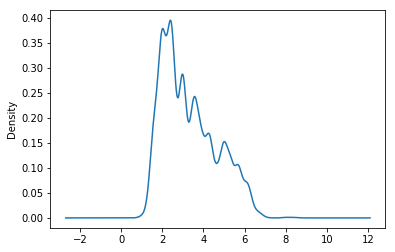

In [27]:
vehiculos.desplazamiento.plot.kde()

Vemos que esta variable desplazamiento tiene un coeficiente de simetria claramente positivo con un peso mayor en la izquierda.

In [28]:
stats.skew(vehiculos.desplazamiento)

0.6267820075196722

Hay dos tecnicas principales para corregir estos dos tipos de problemas y mejorar nuestros modelos.

# Normalizacion
Tambien se le llama min-max scaling

Normalizacion convierte una variable numerica con un rango[0,1]. Muchos modelos de deep learning exigen esto como requisito.

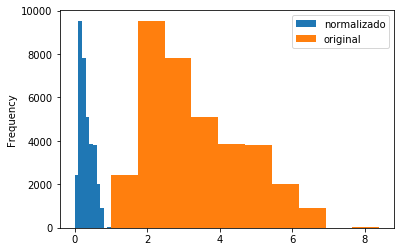

In [29]:
desplazamiento_x_min=vehiculos.desplazamiento.min()
desplazamiento_x_max=vehiculos.desplazamiento.max()

desplazamiento_original=vehiculos.desplazamiento
#Para cada record se le resta el minimo y se divide entre el desplazamiento maximo menos el minimo
desplazamiento_normalizado=desplazamiento_original.apply(lambda x: (x-desplazamiento_x_min)/(desplazamiento_x_max-desplazamiento_x_min))

desplazamiento_normalizado.plot.hist(label="normalizado")
desplazamiento_original.plot.hist(label="original")
plt.legend();

# Estandarizacion. 


Muchos algoritmos nesesitan que todas las variables tengan una distribucion normal. De hecho, la libreria principal que vamos a usar para machine learning lo especifica en su documentacion.

Estandarizacion se puede realizar facilmente convirtiendo cada valor con su puntacion Z, con la formula:

$$z(x)=\frac{x-\mu}{\sigma}$$

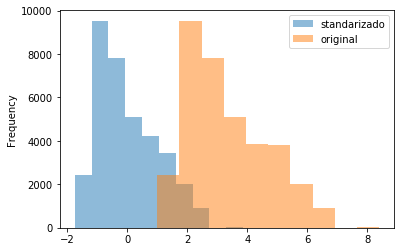

In [30]:
desplazamiento_mu=vehiculos.desplazamiento.mean()
desplazamiento_sigma=vehiculos.desplazamiento.std()
desplazamiento_estandarizado=desplazamiento_original.apply(lambda x:(x-desplazamiento_mu)/desplazamiento_sigma)

desplazamiento_estandarizado.plot.hist(label="standarizado",alpha=0.5)
desplazamiento_original.plot.hist(label="original",alpha=0.5)
plt.legend();

En cuanto elegir normalizacion o estandarizacion, esta desicion esta sujeta a debate.

Si los algoritmos que se desea usar se requiere una estructura de los datos concreta, entonces no hay que tomar desicion , simplemente seguir lid requisitos de decho algoritmo.

Un problema que tiene la normalizacion es que la distancia absoluta entre los valores del dataset al agruparlos todos en un grupo tan pequeño. Por lo tanto si los datos varian mucho es mejor probar a estandarizar primero en vez de normalizar. No obstante no es mala idea probar a mbos procesos y ver cual da los mejores resultados.

Por ejemplo vamos a hacer un grafico de dispersion para ver la comparacion de las variables displ(desplazamiento del motor) y comb08(consumo de combustible) en funcion de si estan noralizadas o estandarizadas.

In [31]:
consumo_original=vehiculos.consumo

consumo_mu=consumo_original.mean()
consumo_sigma=consumo_original.std()
consumo_max=consumo_original.max()
consumo_min=consumo_original.min()

consumo_estandarizado=consumo_original.apply(lambda x:(x-consumo_mu)/(consumo_sigma))
consumo_normalizado=consumo_original.apply(lambda x:(x-consumo_min)/(consumo_max-consumo_min))

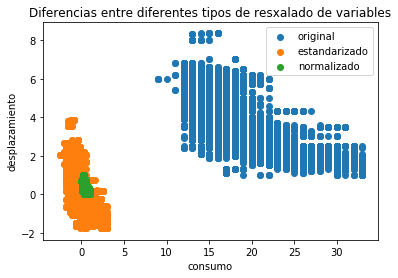

In [32]:
plt.scatter(x=consumo_original,y=desplazamiento_original,label="original")
plt.scatter(x=consumo_estandarizado,y=desplazamiento_estandarizado,label="estandarizado")
plt.scatter(x=consumo_normalizado,y=desplazamiento_normalizado,label="normalizado")

plt.xlabel("consumo")
plt.ylabel("desplazamiento")
plt.title("Diferencias entre diferentes tipos de resxalado de variables")
plt.legend();

Vemos que cuando las variables estan estadarizadas, pese a que su rango es menor (entre -3 y 3 aproximadamente) vemos que refleja la relacion entre ambas variables(incluyendo el outlier en comb08).

Cuando las variables estan normalizadas al estar "encajonadas" en el intervalo [0,1] cuesta ver mas su relacion cuando se comparan con la distribucion original.

Esto no implica que dicha relacion de la distribucion se altere, simplemente que los valores se separan de los elementos de la variable se ven reducidos. Esto altera como cieros métodos de aprendizaje alcanzan soluciones optimas.

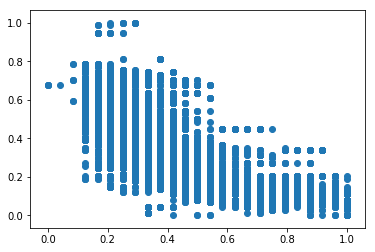

In [37]:
plt.scatter(x=consumo_normalizado,y=desplazamiento_normalizado,label="Normalizado")

En nuestro caso decidimos asignar dos columnas nuevas como las variables estandarizadas

In [34]:
vehiculos["consumo_std"]=consumo_estandarizado
vehiculos["desplazamiento_std"]=desplazamiento_estandarizado

In [35]:
vehiculos.head()

,fabricante,model,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,consumo_std,desplazamiento_std
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,-0.652294,-0.606210
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,-0.652294,-0.606210
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,-1.568056,0.683145
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,-1.568056,0.683145
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,-0.881235,-0.606210


Finalmente, guardamos a csv el dataset_limpio

In [38]:
vehiculos.to_csv("/home/jose/data/vehiculos_procesado.csv",index=False)